In [21]:
import requests
from bs4 import BeautifulSoup
import csv
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import pandas as pd
from IPython.display import display

url = 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_football_2024-2025'

response = requests.get(url)
response.raise_for_status()
soup = BeautifulSoup(response.text, 'html.parser')

tables = soup.find_all('table', {'class': 'wikitable'})
target_table = None
for table in tables:
    headers = [th.get_text(strip=True) for th in table.find_all('th')]
    if 'Club' in headers and 'Stade' in headers:
        target_table = table
        break

if not target_table:
    print("❌ tableau pas trouvé.")
    exit()

geolocator = Nominatim(user_agent="ligue1_mapper")

def geocode_with_retry(query):
    try:
        location = geolocator.geocode(f"{query}, France")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        time.sleep(1)
        return geocode_with_retry(query)

# Extraction des données
clubs_data = []
for row in target_table.find_all('tr')[1:]:
    cells = row.find_all(['td', 'th'])
    if len(cells) < 7:
        continue

    club = cells[0].get_text(strip=True)
    derniere_montee = cells[1].get_text(strip=True)
    classement = cells[2].get_text(strip=True)
    entraineur = cells[3].get_text(strip=True)
    stade = cells[5].get_text(strip=True)
    capacite = cells[6].get_text(strip=True)
    saisons_L1 = cells[7].get_text(strip=True)

    lat, lon = geocode_with_retry(stade)
    time.sleep(1)

    clubs_data.append({
        'Club': club,
        'Dernière montée': derniere_montee,
        'Classement (dernier disponible)': classement,
        'Entraîneur': entraineur,
        'Stade': stade,
        'Capacité': capacite,
        'Nombre de saisons en L1': saisons_L1,
        'Latitude': lat,
        'Longitude': lon
    })

# Enregistrement dans un fichier CSV
csv_path = 'clubs_ligue1_2024_2025.csv'
with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = [
        'Club', 'Dernière montée', 'Classement (dernier disponible)', 'Entraîneur',
        'Stade', 'Capacité', 'Nombre de saisons en L1', 'Latitude', 'Longitude'
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for club in clubs_data:
        writer.writerow(club)

print("✅ Données enregistrées dans", csv_path)

# 📋 Affichage du CSV dans le notebook
df = pd.read_csv(csv_path)
display(df)

✅ Données enregistrées dans clubs_ligue1_2024_2025.csv


,Club,Dernière montée,Classement (dernier disponible),Entraîneur,Stade,Capacité,Nombre de saisons en L1,Latitude,Longitude
0,Paris Saint-Germain,1974,1er,Luis Enrique,Parc des Princes,47 929,52,48.841363,2.253069
1,AS Monaco,2013,2e,Adi Hütter,Stade Louis-II,16 500,66,45.995172,1.040207
2,Stade brestois 29,2019,3e,Éric Roy,Stade Francis-Le Blé,15 220,19,48.403042,-4.461360
3,LOSC Lille,2000,4e,Bruno Genesio,Stade Pierre-Mauroy,50 186,65,50.611904,3.130508
4,OGC Nice,2002,5e,Franck Haise,Allianz Riviera,35 596,66,43.705148,7.192603
5,Olympique lyonnais,1989,6e,Paulo Fonseca,Groupama Stadium,57 206,67,45.765362,4.982054
6,RC Lens,2020,7e,Will Still,Stade Bollaert-Delelis,38 223,63,50.432810,2.814988
7,Olympique de Marseille,1996,8e,Roberto De Zerbi,Orange Vélodrome,66 226,75,43.269835,5.395912
8,Stade de Reims,2018,9e,Samba Diawara,Stade Auguste-Delaune,20 546,40,49.247076,4.024787
9,Stade rennais FC,1994,10e,Habib Beye,Roazhon Park,29 778,68,48.107565,-1.712654


In [16]:
import pandas as pd
import folium
import re
from ipywidgets import interact, IntSlider, Dropdown
from IPython.display import display

df = pd.read_csv("clubs_ligue1_2024_2025.csv")

df["Capacité"] = df["Capacité"].astype(str).str.replace(r"\s|\u202f", "", regex=True).str.replace(r"\[.*?\]", "", regex=True)
df["Capacité"] = pd.to_numeric(df["Capacité"], errors="coerce")

region_map = {
    "Parc des Princes": "Île-de-France",
    "Stade Louis-II": "Provence-Alpes-Côte d'Azur", 
    "Stade Francis-Le Blé": "Bretagne",
    "Stade Pierre-Mauroy": "Hauts-de-France",
    "Allianz Riviera": "Provence-Alpes-Côte d'Azur",
    "Groupama Stadium": "Auvergne-Rhône-Alpes",
    "Stade Bollaert-Delelis": "Hauts-de-France",
    "Orange Vélodrome": "Provence-Alpes-Côte d'Azur",
    "Stade Auguste-Delaune": "Grand Est",
    "Roazhon Park": "Bretagne",
    "Stadium de Toulouse": "Occitanie",
    "Stade de la Mosson": "Occitanie",
    "Stade de la Meinau": "Grand Est",
    "Stade de la Beaujoire": "Pays de la Loire",
    "Stade Océane": "Normandie",
    "Stade de l'Abbé-Deschamps": "Bourgogne-Franche-Comté",
    "Stade Raymond-Kopa": "Pays de la Loire",
    "Stade Geoffroy-Guichard": "Auvergne-Rhône-Alpes"
}


df["Région"] = df["Stade"].map(region_map)

df = df.dropna(subset=["Latitude", "Longitude", "Capacité"])

def afficher_carte(capacite_min, region):
    m = folium.Map(location=[46.5, 2.5], zoom_start=6)
    
    df_filtre = df[df["Capacité"] >= capacite_min]
    
    if region != "Toutes":
        df_filtre = df_filtre[df_filtre["Région"] == region]
    
    for _, row in df_filtre.iterrows():
        folium.Marker(
            location=[row["Latitude"], row["Longitude"]],
            tooltip=row["Stade"]  # 🟡 Affiche au survol uniquement
        ).add_to(m)
    
    return m

regions = ["Toutes"] + sorted(df["Région"].dropna().unique())
interact(
    afficher_carte,
    capacite_min=IntSlider(min=10000, max=70000, step=5000, value=20000, description="Capacité min"),
    region=Dropdown(options=regions, value="Toutes", description="Région")
);


interactive(children=(IntSlider(value=20000, description='Capacité min', max=70000, min=10000, step=5000), Dro…

📊 Tableau des capacités des stades de Ligue 1 :

                  Club                     Stade  Capacité
Olympique de Marseille          Orange Vélodrome     66226
    Olympique lyonnais          Groupama Stadium     57206
            LOSC Lille       Stade Pierre-Mauroy     50186
   Paris Saint-Germain          Parc des Princes     47929
      AS Saint-Étienne   Stade Geoffroy-Guichard     41965
               RC Lens    Stade Bollaert-Delelis     38223
              OGC Nice           Allianz Riviera     35596
             FC Nantes     Stade de la Beaujoire     35322
           Toulouse FC       Stadium de Toulouse     33150
      Stade rennais FC              Roazhon Park     29778
         RC Strasbourg        Stade de la Meinau     26109
           Le Havre AC              Stade Océane     25178
       Montpellier HSC        Stade de la Mosson     22000
        Stade de Reims     Stade Auguste-Delaune     20546
            Angers SCO        Stade Raymond-Kopa     19350
       

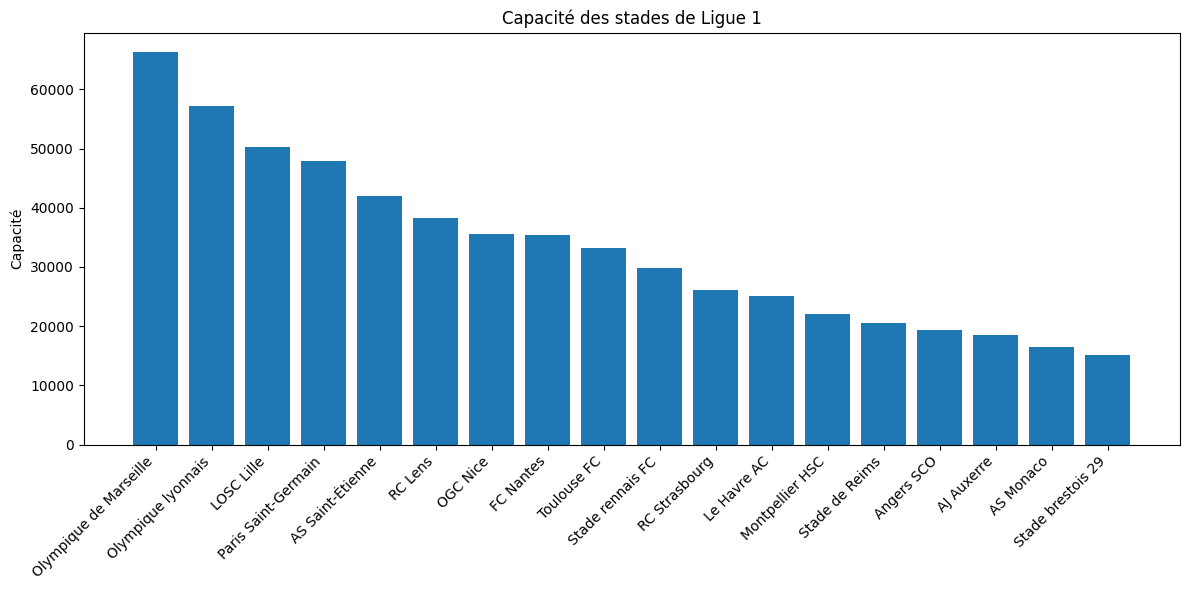

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import re

df = pd.read_csv("clubs_ligue1_2024_2025.csv")

df["Capacité"] = df["Capacité"].astype(str).str.replace(r"\s|\u202f", "", regex=True).str.replace(r"\[.*?\]", "", regex=True)
df["Capacité"] = pd.to_numeric(df["Capacité"], errors="coerce")

df_table = df[["Club", "Stade", "Capacité"]].sort_values(by="Capacité", ascending=False)
print("📊 Tableau des capacités des stades de Ligue 1 :\n")
print(df_table.to_string(index=False))

plt.figure(figsize=(12, 6))
df_sorted = df.sort_values(by="Capacité", ascending=False)
plt.bar(df_sorted["Club"], df_sorted["Capacité"])
plt.xticks(rotation=45, ha='right')
plt.title("Capacité des stades de Ligue 1")
plt.ylabel("Capacité")
plt.tight_layout()
plt.show()